In [59]:
import json # import json module
import os
import os.path as pth
from glob import glob
import cv2
import matplotlib.image as img
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image 

print('ready')


ready


In [2]:
# with statement
with open('./data/for_predict_color/list_description_inshop.json') as json_file:
    json_data = json.load(json_file)
    

color_list = []
for i in json_data:
    color_list.append(i['color'])
    
color_set = set(color_list)


print(len(color_list))
print(len(color_set))

8081
805


In [3]:
id_list = []
for i in json_data:
    id_list.append(i['item'])
    
id_set = set(id_list)


print(len(id_list))
print(len(id_set))
print(json_data[3])

8081
7982
{'item': 'id_00000004', 'color': 'Black-cream', 'description': ['Made to stun with an effortlessly ethereal, bohemian design, this open-shoulder top is crafted from crinkled gauze with long bell sleeves and a tasseled self-tie neckline. Those details would be enough to lend it a covetable look, but the contrast geo embroidery along its bodice is what makes it classically chic. ', 'Unlined', 'Lightweight, woven', '100% rayon', '24" full length, 43" chest, 45" waist, 26" sleeve length', 'Measured from Small', 'Hand wash cold', 'Made in China']}


In [4]:
df_cloth_bbox = pd.read_csv('./data/for_predict_color/list_bbox_inshop.txt', sep='\s+', skiprows=1)
display(df_cloth_bbox.head())

,image_name,clothes_type,pose_type,x_1,y_1,x_2,y_2
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_fron...,1,1,50,49,208,235
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side...,1,2,119,48,136,234
2,img/WOMEN/Blouses_Shirts/id_00000001/02_3_back...,1,3,50,42,213,240
3,img/WOMEN/Blouses_Shirts/id_00000001/02_4_full...,1,4,82,30,162,129
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,3,1,65,45,233,252


In [60]:
path_color_classi = os.path.join('./data/for_predict_color/img')

path_list = glob(os.path.join(path_color_classi, '*', '*', '*', '*.jpg'))

for i in range(20):
    print(path_list[i])

./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_3_back.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_1_front.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_7_additional.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_2_side.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00000879/01_1_front.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00000879/01_3_back.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00000879/01_2_side.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00000879/01_7_additional.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00003741/03_7_additional.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00003741/04_4_full.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00003741/04_2_side.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00003741/03_4_full.jpg
./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00003741/04_1_f

In [66]:
def make_crop(file_path, my_bbox_df):
    img = Image.open(file_path)
    crop_square = (my_bbox_df['x_1'], my_bbox_df['y_1'], my_bbox_df['x_2'], my_bbox_df['y_2'])
    
    crop_img = img.crop(crop_square)
    
    return crop_img


print('img'+path_list[0][28:])
print(df_cloth_bbox.loc[df_cloth_bbox['image_name'] == 'img'+path_list[0][28:]]['x_1'])

img/WOMEN/Blouses_Shirts/id_00004151/02_3_back.jpg
27277    74
Name: x_1, dtype: int64


In [67]:
# 이미지들의 id별로 path확보

path_color_classi = os.path.join('./data/for_predict_color/img')

tmp_list = []
img_path_sort_by_id = {}
for i in id_set:
    tmp_list = glob(os.path.join(path_color_classi, '*', '*', i, '*.jpg'))
    img_path_sort_by_id[i] = tmp_list

print(img_path_sort_by_id['id_00004151'])

['./data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_3_back.jpg', './data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_1_front.jpg', './data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_7_additional.jpg', './data/for_predict_color/img/WOMEN/Blouses_Shirts/id_00004151/02_2_side.jpg']


In [68]:
# 이미지의 id와 color로 이루어진 튜플로 리스트 만들기

id_color_list = []
for i in json_data:
    id_color_list.append((i['item'], i['color']))
    
print(id_color_list[0:10])

[('id_00000001', 'Cream'), ('id_00000002', 'Black-blush'), ('id_00000003', 'Heather grey'), ('id_00000004', 'Black-cream'), ('id_00000005', 'Burgundy'), ('id_00000006', 'Heather grey-black'), ('id_00000007', 'Heather grey-black'), ('id_00000008', 'Black'), ('id_00000009', 'Cream-multi'), ('id_00000010', 'Black')]


In [69]:
img_color_and_path = {}

for i in color_set:
    tmplist = []
    for j in id_color_list:
        if i == j[1]:
            paths = glob(os.path.join(path_color_classi, '*', '*', j[0], '*.jpg'))
            tmplist = tmplist + paths
        else:
            pass
    img_color_and_path[i] = tmplist

In [105]:

tmp = 0
n = 0 
del_list = []
for i in img_color_and_path:
    if len(img_color_and_path[i]) > 100:
        print(i, ' : ',len(img_color_and_path[i]))
        tmp += len(img_color_and_path[i])
        n += 1
    else:
        del_list.append(i)
    
print(' ')
print(' ')
print(tmp)
print(n)

for i in del_list:
    del img_color_and_path[i]

Wine  :  661
Black-grey  :  280
Dark denim  :  167
White-black  :  1156
Light blue  :  367
Lime  :  204
Lavender  :  185
Oatmeal  :  605
Seafoam  :  171
Burgundy  :  2569
White  :  650
Black-white  :  953
Dark grey  :  114
Olive  :  1247
Black-pink  :  215
Bubble gum  :  187
Rose  :  327
Navy-red  :  201
Blue-white  :  282
Khaki  :  335
Cream-black  :  1756
Rust  :  1016
Peacock  :  270
Amber  :  654
Denim  :  604
Red-cream  :  238
Heather grey  :  1576
Taupe  :  691
Blue-black  :  116
Grey-black  :  131
Indigo  :  533
Orange  :  117
Cream-grey  :  142
Light denim  :  630
Cream-multi  :  261
Cream-navy  :  189
Peach  :  228
White-navy  :  116
Black-gold  :  171
Taupe-cream  :  118
Blue-multi  :  133
Heather grey-black  :  358
Heather grey-white  :  156
Hot pink  :  118
Cream-blue  :  157
Periwinkle  :  261
Georgia peach  :  220
Blue  :  226
Black-taupe  :  178
Cream-red  :  128
Purple  :  148
Black-red  :  270
Blush  :  909
Taupe-black  :  134
Tangerine  :  112
Black-multi  :  286
Whit

                                      image_name  clothes_type  pose_type  \
243  img/WOMEN/Dresses/id_00000041/03_2_side.jpg             3          2   

     x_1  y_1  x_2  y_2  
243   77    1  179  232  
img/WOMEN/Dresses/id_00000041/03_2_side.jpg


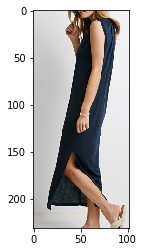

In [112]:
def make_crop(file_path, my_bbox_df):
    img = Image.open(file_path)
    crop_square = (my_bbox_df['x_1'], my_bbox_df['y_1'], my_bbox_df['x_2'], my_bbox_df['y_2'])
    
    crop_img = img.crop(crop_square)
    
    return crop_img


filepath = img_color_and_path['Navy'][10]

# img = Image.open(filepath)
# print(img.size)
# print(img.format)

print(df_cloth_bbox.loc[df_cloth_bbox['image_name'] == filepath[25:]])
print(filepath[25:])


img = make_crop(filepath, df_cloth_bbox.loc[df_cloth_bbox['image_name'] == filepath[25:]])
npimg = np.array(img)
plt.imshow(npimg)


In [ ]:
# def make_folder(folder_name): # 폴더 생성 함수

#     if not os.path.isdir(folder_name):
#         os.mkdir(folder_name)
        

# for i in my_category_dict:
#     make_folder('./data/train_by_category/img_category/' + i + '/')
#     print(i)